# PCA분석을 위한 최적의 컴포넌트 수 찾기

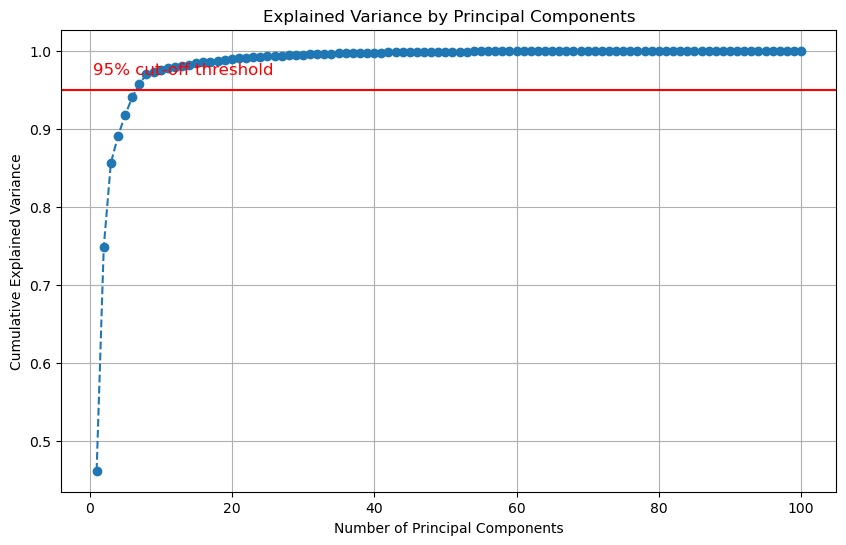

Number of components to retain 95% variance: 7


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## 해당 코드는 PCA분석에서 n개의 컴포넌트를 선택하기 위한 설명분산비율 그래프 출력 -> 정규화 진행 안할 시, 95% 설명력은 7개의 컴포넌트면 충분

# Load the datasets
features_path = 'features_reduced_imputed.csv'
target_path = 'target.csv'

features_df = pd.read_csv(features_path)
target_df = pd.read_csv(target_path)

# Dropping the index column from both dataframes
features_df.drop(columns=['Unnamed: 0'], inplace=True)
target_df.drop(columns=['Unnamed: 0'], inplace=True)


# Performing PCA
pca = PCA()
principal_components = pca.fit_transform(features_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plotting the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.97, '95% cut-off threshold', color='red', fontsize=12)
plt.show()

# Determine the number of components for 90% variance
num_components = (cumulative_explained_variance >= 0.95).argmax() + 1
print(f'Number of components to retain 95% variance: {num_components}')


# SMOTE 기법 활용으로 데이터 증강, 이후 PCA분석 시각화

In [4]:
!pip3 install -U imbalanced-learn

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE

# Load the datasets
features_path = 'features_reduced_imputed.csv'
target_path = 'target.csv'

features_df = pd.read_csv(features_path)
target_df = pd.read_csv(target_path)

# Dropping the index column from both dataframes
features_df.drop(columns=['Unnamed: 0'], inplace=True)
target_df.drop(columns=['Unnamed: 0'], inplace=True)


# Splitting the data into training and testing sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df['LET_IS'], test_size=0.3, random_state=42)

print(X_train.shape)
# SMOTE를 사용하여 데이터 증강
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)

# PCA 수행
num_components = 7
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(X_train_smote)

# 결과를 데이터프레임으로 변환
pca_columns = [f'Principal Component {i+1}' for i in range(num_components)]
pca_df_smote = pd.DataFrame(data=principal_components, columns=pca_columns)
pca_df_smote = pd.concat([pca_df_smote, pd.DataFrame({'LET_IS': y_train_smote})], axis=1)

# PCA 결과 시각화
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

correlations_smote = []

for i in range(num_components):
    ax = axes[i]
    scatter = ax.scatter(pca_df_smote[f'Principal Component {i+1}'], pca_df_smote['LET_IS'], c=pca_df_smote['LET_IS'], cmap='viridis', alpha=0.5)
    ax.set_title(f'PC {i+1} vs LET_IS (SMOTE)')
    ax.set_xlabel(f'PC {i+1}')
    ax.set_ylabel('LET_IS')
    ax.grid(True)
    fig.colorbar(scatter, ax=ax, label='LET_IS')
    
    # Calculate correlation
    correlation = np.corrcoef(pca_df_smote[f'Principal Component {i+1}'], pca_df_smote['LET_IS'])[0, 1]
    correlations_smote.append(correlation)
    ax.annotate(f'corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='red',
                horizontalalignment='left', verticalalignment='top')

# Hide any unused subplots
for j in range(num_components, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print correlations
for i in range(num_components):
    print(f'Correlation between PC{i+1} and LET_IS (SMOTE): {correlations_smote[i]:.2f}')

(1190, 100)


ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.

## -> 이후 train_X, train_Y는 SMOTE가 적용된 버전으로 사용!

# 랜덤포레스트 적용, 정확도 vs OOB (by Original data, PCA data)

Accuracy with original data: 0.86
OOB Score with original data: 1.00
Accuracy with PCA data: 0.70
OOB Score with PCA data: 0.96


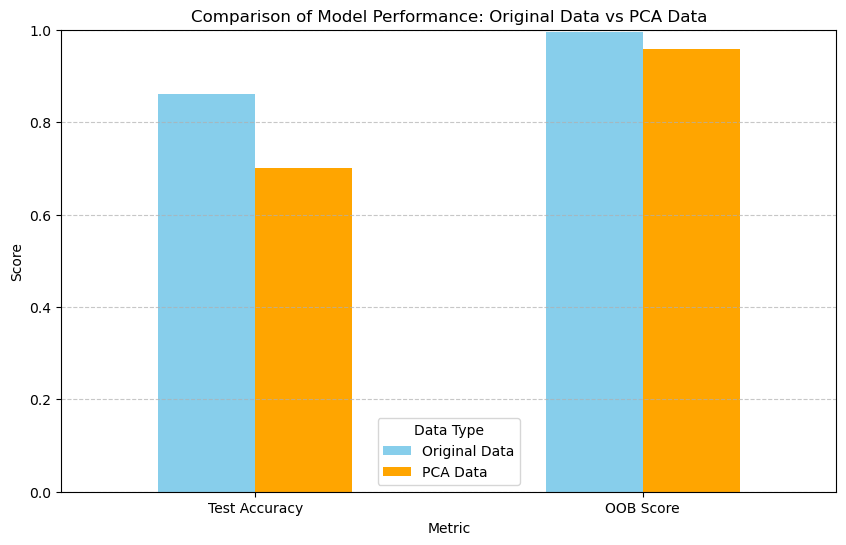

In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Random Forest on original data
rf_original = RandomForestClassifier(random_state=42, oob_score=True)
rf_original.fit(X_train_smote, y_train_smote)
y_pred_original = rf_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
oob_score_original = rf_original.oob_score_
print(f'Accuracy with original data: {accuracy_original:.2f}')
print(f'OOB Score with original data: {oob_score_original:.2f}')

# Performing PCA with 7 components without scaling
num_components = 7
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

# Random Forest on PCA data
rf_pca = RandomForestClassifier(random_state=42, oob_score=True)
rf_pca.fit(X_train_pca, y_train_smote)
y_pred_pca = rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
oob_score_pca = rf_pca.oob_score_
print(f'Accuracy with PCA data: {accuracy_pca:.2f}')
print(f'OOB Score with PCA data: {oob_score_pca:.2f}')

# Creating a dataframe for visualization
comparison_df = pd.DataFrame({
    'Metric': ['Test Accuracy', 'OOB Score'],
    'Original Data': [accuracy_original, oob_score_original],
    'PCA Data': [accuracy_pca, oob_score_pca]
})

# Plotting the comparison
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Comparison of Model Performance: Original Data vs PCA Data')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.legend(title='Data Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

accuracy_original_rf = accuracy_original
accuracy_pca_rf = accuracy_pca

In [12]:
!pip install xgboost

# 로지스틱 회귀, SVM, XGBoost, KNN 정확도 비교

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Dictionary to store the accuracies
accuracies = {}

# Training and evaluating each model on original data
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# 위의 랜덤포레스트 값 추가
accuracies['Random Forest'] = accuracy_original_rf

# Dictionary to store the accuracies for PCA data
accuracies_pca = {}

# Training and evaluating each model on PCA data
for name, model in models.items():
    model.fit(X_train_pca, y_train_smote)
    y_pred_pca = model.predict(X_test_pca)
    accuracies_pca[name] = accuracy_score(y_test, y_pred_pca)
    
accuracies_pca['Random Forest'] = accuracy_pca_rf




# Creating a dataframe for visualization
comparison_df1 = pd.DataFrame({
    'Metric': list(accuracies.keys()),
    'Original Data': list(accuracies.values()),
    'PCA Data': list(accuracies_pca.values())
})

# Plotting the comparison
comparison_df1.set_index('Metric').plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'])
plt.title('Model Performance Comparison: Original Data vs PCA Data')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.legend(title='Data Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

comparison_df1


# 의사결정트리, 나이브베이즈, AdaBoost, LDA 정확도 비교

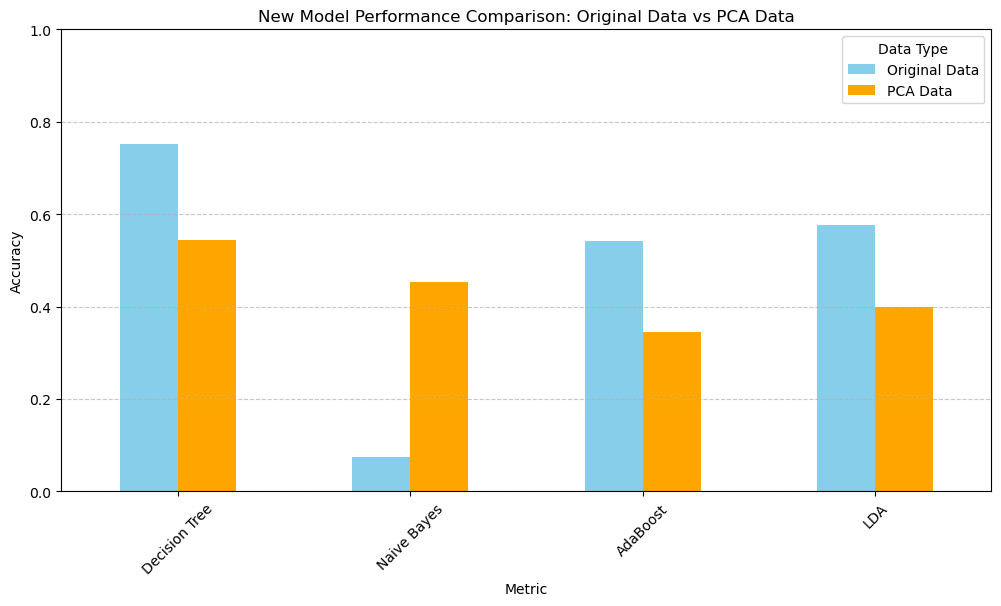

,Metric,Original Data,PCA Data
0,Decision Tree,0.752941,0.543137
1,Naive Bayes,0.074510,0.452941
2,AdaBoost,0.541176,0.345098
3,LDA,0.576471,0.400000


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Initializing new models
new_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LDA': LinearDiscriminantAnalysis()
}

# Dictionary to store the new accuracies
new_accuracies = {}
new_accuracies_pca = {}

# Training and evaluating each new model on original data
for name, model in new_models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    new_accuracies[name] = accuracy_score(y_test, y_pred)

# Training and evaluating each new model on PCA data
for name, model in new_models.items():
    model.fit(X_train_pca, y_train_smote)
    y_pred_pca = model.predict(X_test_pca)
    new_accuracies_pca[name] = accuracy_score(y_test, y_pred_pca)

# Creating a dataframe for visualization
comparison_df2 = pd.DataFrame({
    'Metric': list(new_accuracies.keys()),
    'Original Data': list(new_accuracies.values()),
    'PCA Data': list(new_accuracies_pca.values())
})

# Plotting the comparison for new models
comparison_df2.set_index('Metric').plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'])
plt.title('New Model Performance Comparison: Original Data vs PCA Data')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.legend(title='Data Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Displaying the accuracies
comparison_df2

In [15]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. Gradient Boosting Machine (LightGBM)
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train_smote, y_train_smote)
y_pred_lgbm = lgbm.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f'LightGBM Accuracy: {accuracy_lgbm:.4f}')

# 2. Ensemble Model (Voting Classifier)
model1 = LogisticRegression(random_state=42)
model2 = RandomForestClassifier(random_state=42)
model3 = lgb.LGBMClassifier(random_state=42)

voting_clf = VotingClassifier(estimators=[
    ('lr', model1), 
    ('rf', model2), 
    ('lgbm', model3)
], voting='hard')
voting_clf.fit(X_train_smote, y_train_smote)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f'Voting Classifier Accuracy: {accuracy_voting:.4f}')

# 3. Neural Network (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train_smote, y_train_smote)
y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f'MLP Accuracy: {accuracy_mlp:.4f}')

# 1. Gradient Boosting Machine (LightGBM) on PCA data
lgbm.fit(X_train_pca, y_train_smote)
y_pred_lgbm_pca = lgbm.predict(X_test_pca)
accuracy_lgbm_pca = accuracy_score(y_test, y_pred_lgbm_pca)
print(f'PCA LightGBM Accuracy: {accuracy_lgbm_pca:.4f}')

# 2. Ensemble Model (Voting Classifier) on PCA data
voting_clf.fit(X_train_pca, y_train_smote)
y_pred_voting_pca = voting_clf.predict(X_test_pca)
accuracy_voting_pca = accuracy_score(y_test, y_pred_voting_pca)
print(f'PCA Voting Classifier Accuracy: {accuracy_voting_pca:.4f}')

# 3. Neural Network (MLP) on PCA data
mlp.fit(X_train_pca, y_train_smote)
y_pred_mlp_pca = mlp.predict(X_test_pca)
accuracy_mlp_pca = accuracy_score(y_test, y_pred_mlp_pca)
print(f'PCA MLP Accuracy: {accuracy_mlp_pca:.4f}')

# Comparing all models
comparison_df3 = pd.DataFrame({
    'Model': ['LightGBM', 'Voting Classifier', 'MLP'],
    'Original Accuracy': [accuracy_lgbm, accuracy_voting, accuracy_mlp],
    'PCA Accuracy': [accuracy_lgbm_pca, accuracy_voting_pca, accuracy_mlp_pca]
})

# Plotting the comparison
comparison_df3.set_index('Model').plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'])
plt.title('Model Performance Comparison: Original Data vs PCA Data')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.legend(title='Data Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Displaying the accuracies
comparison_df3


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16076
[LightGBM] [Info] Number of data points in the train set: 8024, number of used features: 88
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

C:\Users\J\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16076
[LightGBM] [Info] Number of data points in the train set: 8024, number of used features: 88
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g